In [287]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import torch
from torch import nn


In [288]:
#Load Mini MNIST from the MATLAB data file - Observe how we load the files

mnist = loadmat('mnist_49_3000.mat')
X = mnist['x']
y = mnist['y'][0]

'''
Test Train Split for Calculating accuracy on a Held Out Test Dataset.
'''
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=1/3, random_state=42)

In [289]:
#We need to change -1 to 0 before fitting logistic regression.

def converter(inp):
    if inp > 0:
        return 1
    else:
        return 0

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor([converter(val) for val in y_train], dtype=torch.float32)
y_test  = torch.tensor([converter(val) for val in y_test], dtype=torch.float32)

In [290]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, X):
        out = self.linear(X)
        out = torch.sigmoid(out)
        return out

class LogisticRegression:
    
    def __init__(self, lr=0.01, lamb = 10, num_iter=1000, fit_intercept=True):
        self.lr = lr
        self.lamb = lamb
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = torch.ones((X.shape[0], 1))
        return torch.concat((intercept, X), axis=1) 
          
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        self.model = LinearRegression(784, 1)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.lamb)
        criterion = nn.CrossEntropyLoss()

        for i in range(self.num_iter):
            outputs = self.model(X)
            loss = criterion(outputs.T[0], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    def predict(self, X, threshold=0.5):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        outputs = self.model(X)

        for i in range(len(outputs)):
            if outputs[i] < threshold:
                outputs[i] = 0
            else:
                outputs[i] = 1

        return outputs.T[0]




In [291]:
def model_factory(lamb):
    model = LogisticRegression(lr=.001, lamb=lamb, fit_intercept=False) 
    model.fit(X_train, y_train)
    return model

def prediction(lamb=.1):
    model = model_factory(lamb)

    #Generate Predictions
    preds = model.predict(X_test) 
    
    # accuracy
    accuracy = (preds == y_test).sum().item() / len(y_test)
    print(f"Lambda: {lamb} Accuary: {accuracy:.2%} Error: {1-accuracy:.2%}")

prediction(100)
prediction(10)
prediction(1)
prediction(.1)
prediction(.01)


Lambda: 100 Accuary: 94.10% Error: 5.90%
Lambda: 10 Accuary: 96.90% Error: 3.10%
Lambda: 1 Accuary: 97.10% Error: 2.90%
Lambda: 0.1 Accuary: 97.20% Error: 2.80%
Lambda: 0.01 Accuary: 97.30% Error: 2.70%


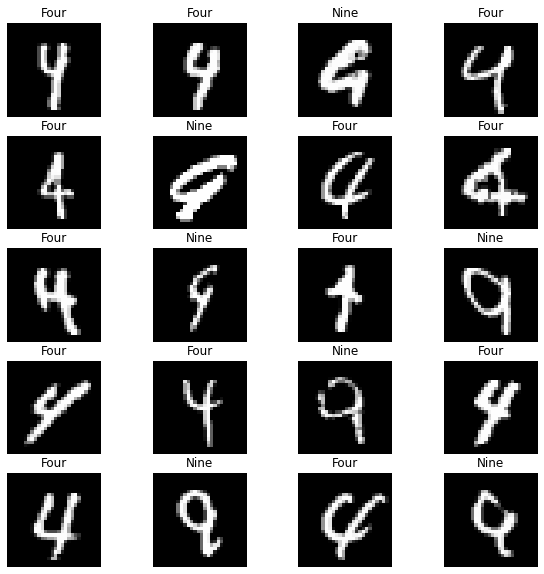

In [292]:
import matplotlib.pyplot as plt


def posterior(w, x):
    return 1 / (1 + torch.exp(-w[0].T @ x))

def confidence(model, X):
    weights = model.model.linear.state_dict()['weight']
    return posterior(weights, X_test.T)

def normalize_conf(conf):
    if conf > 0.5:
        return 1 - conf
    return conf


model = model_factory(.1)
preds = model.predict(X_test)
correct = preds == y_test
conf = confidence(model, X_test)

incorrect_conf = [
    (normalize_conf(conf[i].item()), X_test[i], y_test[i].item()) 
    for i in range(len(preds)) if not correct[i]
]

incorrect_conf = sorted(incorrect_conf, key=lambda v: v[0])

labels = ['Four', 'Nine']

plt.figure(figsize=(10, 10))

for i, (_, data, actual) in enumerate(incorrect_conf[0:20]):
    plt.subplot(5, 4, i + 1)
    plt.imshow(data.reshape(28, 28), cmap="gray")
    plt.title(labels[int(actual)])
    plt.axis("off")

plt.show()
    

